<a href="https://colab.research.google.com/github/chejige/Weekly-Sales-prediction/blob/main/Weekly_Sales_prediction_(Prophet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [150]:
!pip install prophet

import prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 80 kB 3.3 MB/s 
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [203]:
# Data representation and computation
import pandas as pd  
import numpy as np  
pd.options.display.float_format = '{:20,.4f}'.format

# Graph plotting
import matplotlib.pyplot as plt  
import seaborn as sns

sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

# Exploring and preparing the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [113]:
#upload the data
df = pd.read_csv('/content/sales per week.csv')

In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date          421570 non-null  object 
 1   Weekly_Sales  421570 non-null  float64
dtypes: float64(1), object(1)
memory usage: 6.4+ MB


In [116]:
from datetime import datetime
df['Date']=df['Date'].apply(lambda x: datetime.strptime(x,'%d/%m/%Y'))

In [156]:
df1=pd.DataFrame(df.groupby(by='Date')['Weekly_Sales'].sum())

In [157]:
df1.head()

,Weekly_Sales
Date,
2010-02-05,"49,750,740.5000"
2010-02-12,"48,336,677.6300"
2010-02-19,"48,276,993.7800"
2010-02-26,"43,968,571.1300"
2010-03-05,"46,871,470.3000"


In [158]:
df1.reset_index(inplace=True)

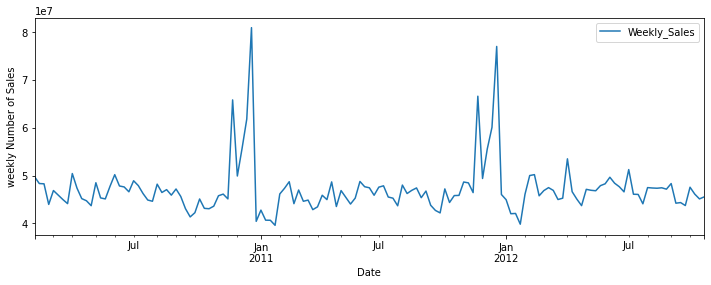

In [159]:
ax = df1.set_index('Date').plot(figsize = (12, 4))
ax.set_ylabel('weekly Number of Sales')
ax.set_xlabel('Date')
plt.show()

In [161]:
# from the prophet documentation every variables should have specific names
sales = df1.rename(columns = {'Date': 'ds',
                                'Weekly_Sales': 'y'})
sales.head()

,ds,y
0,2010-02-05,"49,750,740.5000"
1,2010-02-12,"48,336,677.6300"
2,2010-02-19,"48,276,993.7800"
3,2010-02-26,"43,968,571.1300"
4,2010-03-05,"46,871,470.3000"


In [171]:
split=int(sales.shape[0]*0.9)
df_train=sales[:split]
df_test=sales[split:]
df_train.shape,df_test.shape

((128, 2), (15, 2))

[Text(0, 0.5, ''), Text(0.5, 1.0, 'Dependent Variable')]

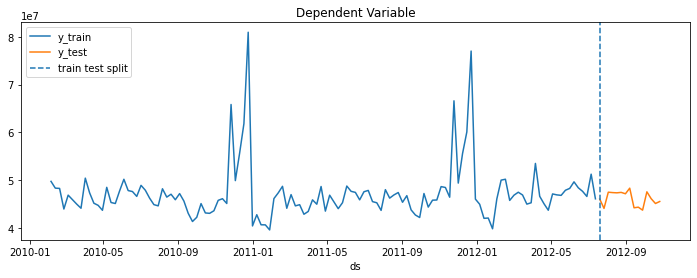

In [181]:
threshold_date=sales.loc[split,'ds']
fig, ax = plt.subplots(figsize = (12, 4))
sns.lineplot(x='ds', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
ax.axvline(threshold_date,  linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='')

In [172]:
from prophet import Prophet
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95,weekly_seasonality=True)
my_model.fit(df_train)

# dataframe that extends into future 6 weeks 
future = my_model.make_future_dataframe(periods=sales.shape[0], freq='W')

print("week to forecast.")
future.tail(7)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puh3olj/s_lb4v0k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9puh3olj/j17wmqsx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37173', 'data', 'file=/tmp/tmp9puh3olj/s_lb4v0k.json', 'init=/tmp/tmp9puh3olj/j17wmqsx.json', 'output', 'file=/tmp/tmp9puh3olj/prophet_modelubn4u98t/prophet_model-20221017065826.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:58:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:58:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


week to forecast.


,ds
264,2015-02-22
265,2015-03-01
266,2015-03-08
267,2015-03-15
268,2015-03-22
269,2015-03-29
270,2015-04-05


In [176]:
# predictions
forecast = my_model.predict(future)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
264,2015-02-22,"51,242,907.8108","43,712,623.8530","58,533,060.6571"
265,2015-03-01,"50,443,738.9418","43,073,412.4927","57,694,494.1984"
266,2015-03-08,"50,354,288.5734","43,298,802.2361","57,350,849.4237"
267,2015-03-15,"50,171,895.9695","42,773,612.0867","57,571,195.3352"
268,2015-03-22,"49,845,470.4697","42,290,846.3784","57,017,289.1751"
269,2015-03-29,"50,074,120.1550","42,683,980.5998","57,018,371.4145"
270,2015-04-05,"51,014,044.4434","43,618,588.5465","58,578,294.2245"


In [210]:
sales.shape[0]

143

In [211]:
forecast_train = forecast[:split]

forecast_test=forecast[split:sales.shape[0]]

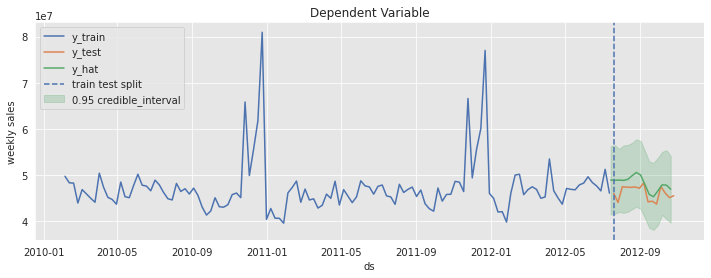

In [212]:
fig, ax = plt.subplots(figsize = (12, 4))

ax.fill_between(
    x=forecast_test['ds'],
    y1=forecast_test['yhat_lower'],
    y2=forecast_test['yhat_upper'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df_train, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', data=forecast_test, ax=ax)
ax.axvline(threshold_date, linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable', ylabel='weekly sales');